# Phase separation prediction

This Colab notebook enables prediction of IDR transfer free energies and saturation concentrations from sequence.
- The models have been trained on CALVADOS 2 slab simulation data.
- Conditions are fixed to T=293 K and I=150 mM.

<b>How to cite this notebook:</b>
- S. von Bülow, G. Tesei & K. Lindorff-Larsen, __Prediction of phase separation propensities of disordered proteins from sequence__ _bioRxiv_ 2024

Further references:
- Use of $\nu_\mathrm{SVR}$: <br>
G. Tesei, A. I. Trolle, N. Jonsson, J. Betz, F. Pesce, K. E. Johansson, K. Lindorff-Larsen, __Conformational ensembles of the human intrinsically disordered proteome__ _Nature_ 2024 626, 897–904 DOI: https://doi.org/10.1038/s41586-023-07004-5
- CALVADOS 2 model: <br>
G. Tesei and K. Lindorff-Larsen, __Improved predictions of phase behaviour of intrinsically disordered proteins by tuning the interaction range [version 2; peer review: 2 approved]__ _Open Research Europe_ 2023 2(94) DOI: https://doi.org/10.12688/openreseurope.14967.2

Author: Sören von Bülow (soren.bulow@bio.ku.dk)

In [1]:
#@title <b>Preliminary operations</b>

import os
import warnings
warnings.simplefilter("ignore")

print('Setting up the environment...')

!rm -r sample_data &> dump
!rm sequence.* &> dump
!rm svr_model_nu* &> dump
!rm residues* &> dump
!rm example* &> dump
!rm predictor.* &> dump
!rm *joblib &> dump

github_folder = 'https://raw.githubusercontent.com/KULL-Centre/_2024_buelow_PSpred/main'

print(f'Downloading files from {github_folder}')

os.system(f'wget {github_folder}/scripts_colab/sequence.py')
os.system(f'wget {github_folder}/scripts_colab/predictor.py')
os.system(f'wget {github_folder}/data/residues.csv')
os.system(f'wget {github_folder}/data/example.fasta')
os.system(f'wget -O model_dG.joblib {github_folder}/models/idrome90/mlp/dG/model.joblib')
os.system(f'wget -O model_logcdil_mgml.joblib {github_folder}/models/idrome90/mlp/logcdil_mgml/model.joblib')
os.system(f'wget -O svr_model_nu.joblib {github_folder}/models/svr_model_nu.joblib')

!pip install 'scikit-learn==1.3' MDAnalysis biopython numba &> dump

import joblib
import sklearn
import pandas as pd

import sequence
from predictor import *

import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab import files

ncrossval = 50
print('Environment set up.')
print('Loading models...')

residues = pd.read_csv('residues.csv').set_index('one')
nu_file = 'svr_model_nu.joblib'

features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']

features_clean = {
    'mean_lambda' : 'lambda',
    'faro' : 'f(aromatics)',
    'shd' : 'SHD',
    'ncpr' : 'NCPR',
    'fcr' : 'FCR',
    'scd' : 'SCD',
    'ah_ij' : 'LJ pairs',
    'nu_svr' : 'nu(SVR)'
}

print('Input features are:')
print('>>>>> '+ ', '.join([features_clean[fe] for fe in features]))

!touch calvados.py

models = {}
models['dG'] = joblib.load(f'model_dG.joblib')
models['logcdil_mgml'] = joblib.load(f'model_logcdil_mgml.joblib')

mltype = 'mlp'
alpha = 5
layers = (10,10)

targets = ['dG','logcdil_mgml']
targets_clean = {
    'dG' : 'Delta G',
    'logcdil_mgml' : 'Saturation concentration',
}

print('Models loaded.')

Setting up the environment...


Environment set up.
Loading models...
Input features are:
>>>>> lambda, f(aromatics), SHD, NCPR, FCR, SCD, LJ pairs, nu(SVR)
Models loaded.


# Predict single sequence

Paste in an aminoacid sequence to predict phase separation propensities. The termini can be charged (unmodified) or not charged (capped), which should only have minor effects on the prediction if the sequence is long.

In [2]:
#@title <b>Run single IDR prediction</font></b>

try:
    os.rmdir('sample_data')
except:
    pass

NAME = "LAF1" #@param {type:"string"}
SEQUENCE = "MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGLEHHHHHH" #@param {type:"string"}
CHARGE_TERMINI = True # @param {type:'boolean'}
TEMPERATURE = "293 K (fixed)" # @param ['293 K (fixed)']
IONIC_STRENGTH = "150 mM (fixed)" # @param ['150 mM (fixed)']

seq = SEQUENCE[:]
if " " in seq:
    seq = ''.join(seq.split())
    print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')

print('='*80)
print(f'NAME: {NAME}')
print(f'SEQUENCE: {seq}')

seqfeats = sequence.SeqFeatures(seq,residues=residues,charge_termini=CHARGE_TERMINI)
X = X_from_seq(seq,features,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file)

for target in targets:
  print('-'*80)
  ys = models[target].predict(X)#,models)
  ys_m = np.mean(ys)

  if target == 'dG':
    output = ys_m
    unit = 'kT'
    lower = ys_m - 1
    upper = ys_m + 1
  elif target == 'logcdil_mgml':
    output = np.exp(ys_m)
    lower = np.exp(ys_m-0.82)
    upper = np.exp(ys_m+0.82)
    unit = 'mg/mL'

  print(f'{targets_clean[target]:25s} = {output:5.1f} {unit:6s} ({lower:.1f} -- {upper:.1f} {unit})')
  if target == 'logcdil_mgml':
    output_uM = output / seqfeats.mw * 1e6
    lower_uM = lower / seqfeats.mw * 1e6
    upper_uM = upper / seqfeats.mw * 1e6
    print(f'{"":25s} = {output_uM:5.1f} {"uM":6s} ({lower_uM:.1f} -- {upper_uM:.1f} {"uM"})')
print('='*80)

NAME: LAF1
SEQUENCE: MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGLEHHHHHH
--------------------------------------------------------------------------------
Delta G                   =  -6.1 kT     (-7.1 -- -5.1 kT)
--------------------------------------------------------------------------------
Saturation concentration  =   1.2 mg/mL  (0.5 -- 2.8 mg/mL)
                          =  69.4 uM     (30.5 -- 157.5 uM)


## Predict variant effects

Below we substitute each of the residues in the above input sequence one by one with any of the 19 other aminoacids. The resulting plot shows the effect on phase separation propensities. Negative values (red) indicate stronger phase separation, positive values (blue) indicate weaker phase separation compared to the input sequence.

In [3]:
#@title <b>Run variant effect prediction</font></b>

p = np.argsort(residues['lambdas'].to_numpy())
sorted_names = residues.index[p]
aminoacids_sorted = "".join(sorted_names)

ah_intgrl_map = sequence.make_ah_intgrl_map(residues)
lambda_map = sequence.make_lambda_map(residues)

target = 'dG'
model = models[target]

seq = SEQUENCE[:]
wt_idx = np.zeros((len(seq)))
dG_map = np.zeros((len(aminoacids_sorted),len(seq)))

seq_feats = sequence.SeqFeatures(seq,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file,
            ah_intgrl_map=ah_intgrl_map,lambda_map=lambda_map)

X = X_from_seq(seq,features,seq_feats=seq_feats)
ys = model.predict(X)
dG_wt = np.mean(ys)

for idx, s in tqdm(enumerate(seq),total=len(seq)):
    wt_idx[idx] = aminoacids_sorted.index(s)
    for jdx, a in enumerate(aminoacids_sorted):
        seq_new = list(seq)
        seq_new[idx] = a
        seq_new = "".join(seq_new)

        seq_feats = sequence.SeqFeatures(seq_new,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file,
                    ah_intgrl_map=ah_intgrl_map,lambda_map=lambda_map)
        X = X_from_seq(seq_new,features,seq_feats=seq_feats)
        ys = model.predict(X)
        ys_m = np.mean(ys)

        dG_map[jdx,idx] = ys_m

100%|██████████| 176/176 [01:22<00:00,  2.13it/s]


Delta G wt: -6.1 kT


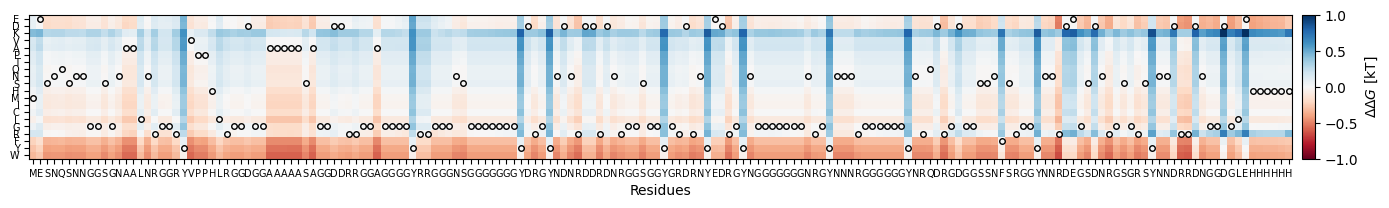

In [5]:
#@title <b>Plot variant effect results</font></b>


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(14,9))#,sharex=True)

_ = ax.imshow(dG_map - dG_wt,cmap=plt.cm.RdBu,vmin=-1,vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)
plt.colorbar(_, cax=cax,label=f'$\Delta \Delta G$ [kT]')

print(f'{targets_clean["dG"]} wt: {dG_wt:.1f} kT')

ax.plot(wt_idx,'o',fillstyle='none',color='black',markersize=4)
ax.set_xticks(np.arange(len(seq)))
ax.set_xticklabels(seq,fontsize=7)
ax.set_yticks(np.arange(len(aminoacids_sorted)))
ax.set_yticklabels(aminoacids_sorted,fontsize=7)
ax.grid(False)
ax.set(xlabel='Residues')

fig.tight_layout()
fig.savefig(f'{NAME}_variants.pdf')

# Batch prediction

An input fasta file can be uploaded. The code below predicts phase separation propensity and saturation concentrations for all sequences in the fasta file.

In [ ]:
#@title <b>Run batch prediction</b>

#@markdown File name
FASTA_FILE = "example.fasta" #@param {type:"string"}
CHARGE_TERMINI = True # @param {type:'boolean'}
TEMPERATURE = "293 K (fixed)" # @param ['293 K (fixed)']
IONIC_STRENGTH = "150 uM (fixed)" # @param ['150 uM (fixed)']

if not os.path.isfile(FASTA_FILE):
  print(f'Please upload file {FASTA_FILE}')
  uploaded = files.upload()
  if FASTA_FILE not in uploaded.keys():
    raise NameError(f'Could not find file {FASTA_FILE}')

records = sequence.read_fasta(FASTA_FILE)

print('-'*80)
print(f'FASTA FILE: {FASTA_FILE}')
print(f'NUMBER OF SEQUENCES: {len(records)}')

#@title <b>Run batch prediction</font></b>

df_records = pd.DataFrame(dtype=object)

for name, record in tqdm(records.items(),total=len(records)):
  seq = str(record.seq)
  df_records.loc[name,'Sequence'] = seq
  seqfeats = sequence.SeqFeatures(seq,residues=residues,
                                  charge_termini=CHARGE_TERMINI,nu_file=nu_file)
  for feat in features:
    df_records.loc[name,feat] = getattr(seqfeats,feat)
  X = X_from_seq(seq,features,residues=residues,
                 charge_termini=CHARGE_TERMINI,nu_file=nu_file)
  for target in targets:
    ys = models[target].predict(X)#,models)
    ys_m = np.mean(ys)
    if target == 'dG':
      df_records.loc[name,'Delta G [kT]'] = ys_m
    if target == 'logcdil_mgml':
      cdil_mgml = np.exp(ys_m)
      df_records.loc[name,'Saturation concentration [mg/mL]'] = cdil_mgml
      cdil_uM = cdil_mgml / seqfeats.mw * 1e6
      df_records.loc[name,'Saturation concentration [uM]'] = cdil_uM

df_records.index.name = 'Name'
df_records.to_csv('df_PSprediction.csv')

print('\n')
print('='*114)
print(f'{"Name":20s} {"Sequence":33s} {"Delta G":>10s} {"Saturation":>16s} {"Saturation":>16s}')
print(f'{"":20s} {"":33s} {"":>10s} {"concentration":>16s} {"concentration":>16s}')
print(f'{"":20s} {"":33s} {"[kT]":>10s} {"[mg/mL]":>16s} {"[uM]":>16s}')

print('='*114)
for key, val in df_records.iterrows():
  if len(list(val["Sequence"])) > 30:
    seqpr = f'{val["Sequence"][:30]:30s}...'
  else:
    seqpr = f'{val["Sequence"][:30]:30s}'
  print(f'{key:20s} {seqpr:33s} {val["Delta G [kT]"]:10.1f} {val["Saturation concentration [mg/mL]"]:16.1f} {val["Saturation concentration [uM]"]:16.1f}')


In [ ]:
#@title <b>Analysis</font></b>

fcolor = plt.cm.summer

fig, ax = plt.subplots(1,2,figsize=(9,4))

for idx, target in enumerate(['Delta G [kT]','Saturation concentration [mg/mL]']):
  axij = ax[idx]
  axij.hist(df_records[target],bins=20,color=fcolor(0))

  axij.set_xlabel(f'{target}')
  axij.set_ylabel('Counts')
  axij.grid(alpha=0.3)
fig.tight_layout()

In [ ]:
#@title <b>Download dataframe</font></b>

files.download('df_PSprediction.csv')